## Imports 

In [70]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import missingno as msno
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder



## Cargar data 

In [71]:

elo_rating = pd.read_csv('../data/EloRatings.csv')
matches = pd.read_csv('../data/Matches.csv')

/tmp/ipykernel_1723/2730516373.py:2: DtypeWarning: Columns (0: MatchTime) have mixed types. Specify dtype option on import or set low_memory=False.
  matches = pd.read_csv('../data/Matches.csv')


## Visualización 

In [72]:
print('Matches shape:', matches.shape)
print('Elo shape:', elo_rating.shape)


Matches shape: (230557, 48)
Elo shape: (245033, 4)


# Limpieza manual 

Breve introducción: a continuación he separado cada paso de la limpieza en celdas individuales (carga, eliminación de columnas constantes, duplicados, redundancias, clasificación, análisis de missing, eliminación por umbral, eliminación de filas con muchos missing, extracción de features y guardado). Ejecuta cada celda en orden y revisa los outputs antes de proceder a la siguiente celda.

### Valores constantes:

In [73]:
# 1. Eliminar columnas constantes (que tienen el mismo valor en todas las filas)
const_cols = [col for col in matches.columns if matches[col].nunique() <= 1]
matches.drop(columns=const_cols, inplace=True)

# 2. Eliminar columnas duplicadas (mismo nombre o contenido idéntico)
matches = matches.loc[:, ~matches.columns.duplicated()]

print(f"Columnas constantes eliminadas: {const_cols}")
print(f"Forma del dataset tras limpieza inicial: {matches.shape}")

Columnas constantes eliminadas: []
Forma del dataset tras limpieza inicial: (230557, 48)


## Eliminación de filas duplicadas y columnas idénticas

In [74]:
### Paso 3 — Eliminar columnas numéricas redundantes por alta correlación
# Parámetros: corr_thresh controla el umbral. Ajusta a 0.99, 0.98, 0.95 según prefieras.

corr_thresh = 0.99
print('Umbral de correlación para eliminación:', corr_thresh)

num = matches.select_dtypes(include=[np.number])
print('Columnas numéricas disponibles:', num.shape[1])

high_pairs = []
if num.shape[1] >= 2:
    corr = num.corr().abs()
    # evitar tocar diagonal si read-only
    for k in range(len(corr.columns)):
        corr.iat[k,k] = 0
    for i in range(len(corr.columns)):
        for j in range(i+1, len(corr.columns)):
            if corr.iloc[i,j] >= corr_thresh:
                high_pairs.append((corr.index[i], corr.columns[j], corr.iloc[i,j]))
    print('Pares con corr >=', corr_thresh, ':', len(high_pairs))
    if high_pairs:
        to_drop = sorted({b for a,b,c in high_pairs})
        print('Columnas propuestas para eliminar (ejemplos hasta 50):', to_drop[:50])
        # Para seguridad, no eliminamos automáticamente: define drop_corr=True para eliminar
        drop_corr = False
        print('drop_corr está en', drop_corr, "— cambia a True si quieres eliminar automáticamente")
        if drop_corr:
            matches.drop(columns=to_drop, inplace=True)
            print('Eliminadas columnas por alta correlación. Nuevo shape:', matches.shape)
else:
    print('No hay suficientes columnas numéricas para evaluar correlación')

Umbral de correlación para eliminación: 0.99
Columnas numéricas disponibles: 41


Pares con corr >= 0.99 : 0


# Data leaked 

In [ ]:
# 1. ANTES DEL PARTIDO 
# Incluimos ELO, Cuotas, Handicaps, Formas y la variable objetivo FTResult
cols_pre = [
    'Division', 'MatchDate', 'MatchTime', 'HomeTeam', 'AwayTeam', 
    'HomeElo', 'AwayElo', 'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away',
    'OddHome', 'OddDraw', 'OddAway', 'MaxHome', 'MaxDraw', 'MaxAway',
    'Over25', 'Under25', 'MaxOver25', 'MaxUnder25', 
    'HandiSize', 'HandiHome', 'HandiAway', 'FTResult' 
]

# 2. DURANTE EL PARTIDO 
cols_durante = [
    'HTHome', 'HTAway', 'HTResult', 'HomeShots', 'AwayShots', 
    'HomeTarget', 'AwayTarget', 'HomeFouls', 'AwayFouls', 
    'HomeCorners', 'AwayCorners', 'HomeYellow', 'AwayYellow', 
    'HomeRed', 'AwayRed'
]

# 3. POST PARTIDO
cols_post = [
    'FTHome', 'FTAway', 'C_LTH', 'C_LTA', 'C_VHD', 'C_VAD', 'C_HTB', 'C_PHB'
]


datos_pre = matches[[c for c in cols_pre if c in matches.columns]].copy()
datos_durante = matches[[c for c in cols_durante if c in matches.columns]].copy()
datos_post = matches[[c for c in cols_post if c in matches.columns]].copy()

print("Variables separadas correctamente.")


Variables separadas correctamente.


# Missing values 

<Axes: >

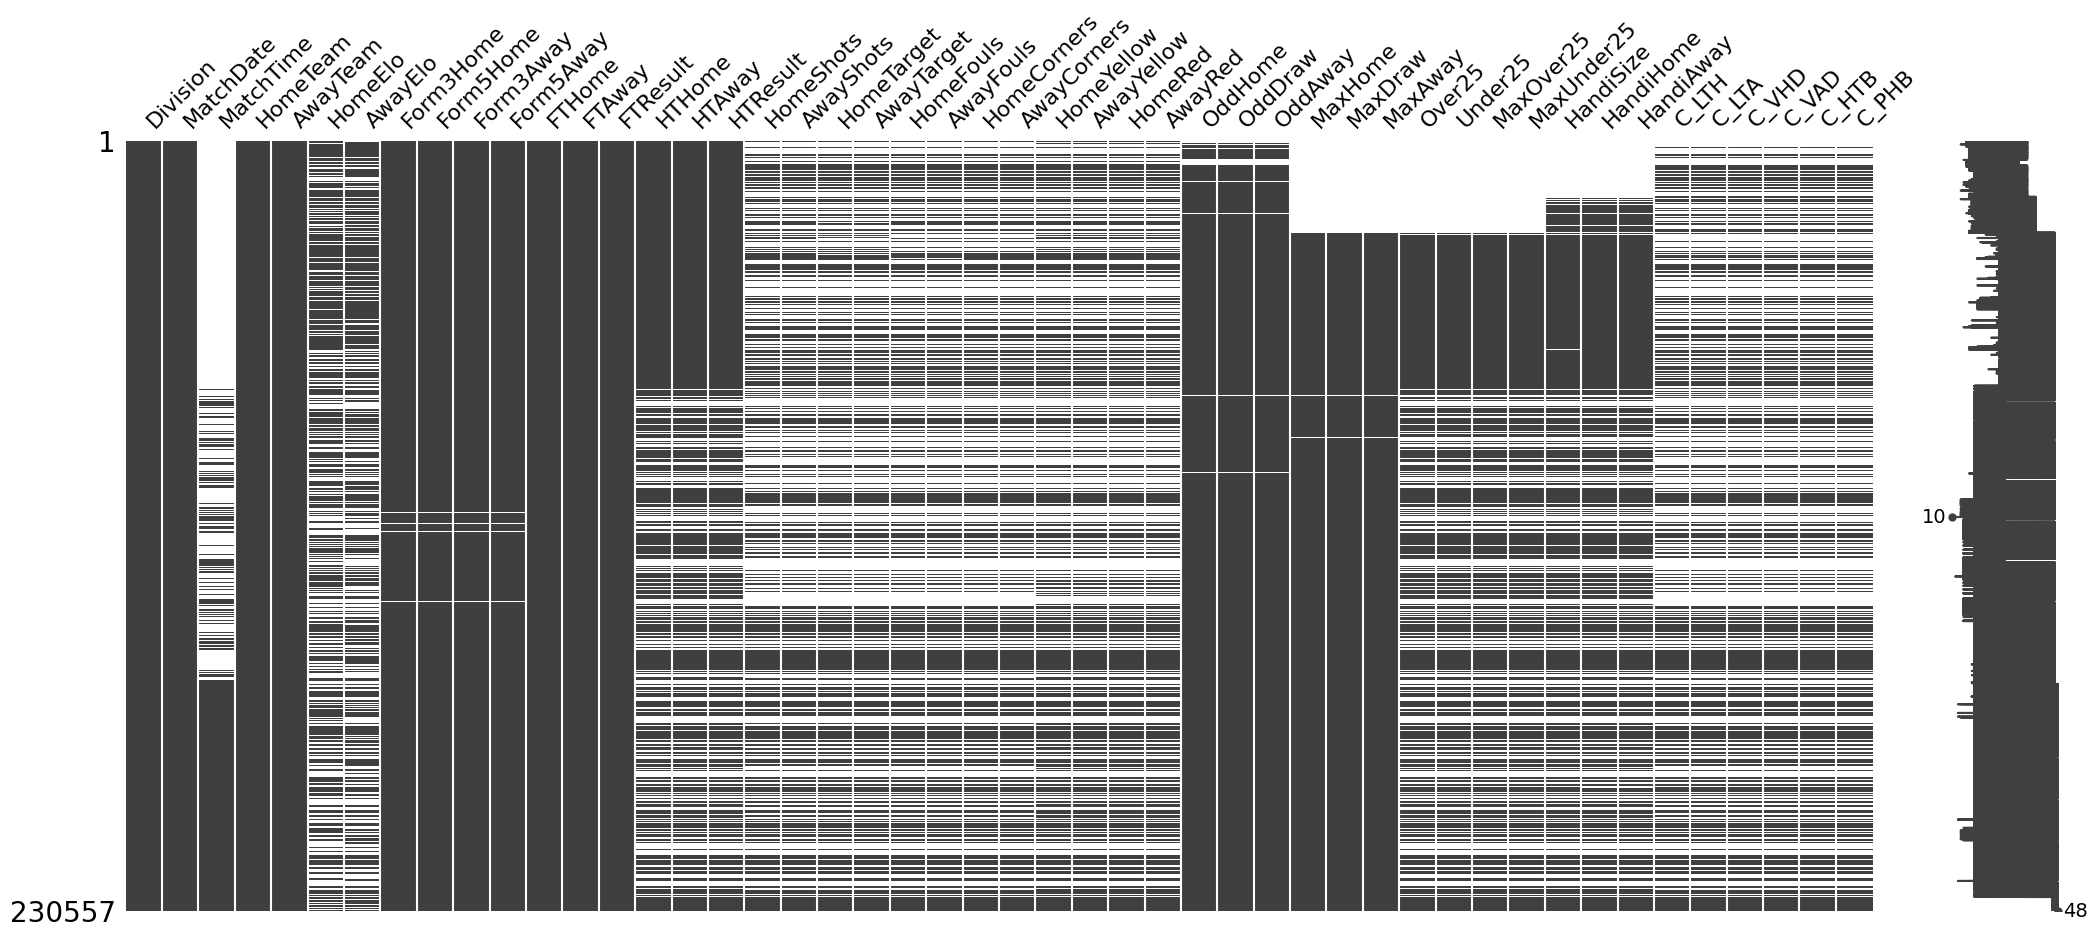

In [76]:
msno.matrix(matches)

In [77]:
# DATOS PRE-PARTIDO
miss_pre = datos_pre.isnull().sum() * 100 / len(datos_pre)
print("\nValores faltantes en DATOS PRE-PARTIDO ---")
print(miss_pre[miss_pre > 0].sort_values(ascending=False))

# DATOS DURANTE EL PARTIDO
miss_durante = datos_durante.isnull().sum() * 100 / len(datos_durante)
print("\nValores faltantes en DATOS DURANTE EL PARTIDO ---")
print(miss_durante[miss_durante > 0].sort_values(ascending=False))

# DATOS POST-PARTIDO
miss_post = datos_post.isnull().sum() * 100 / len(datos_post)
print("\nValores faltantes en DATOS POST-PARTIDO ---")
print(miss_post[miss_post > 0].sort_values(ascending=False))



Valores faltantes en DATOS PRE-PARTIDO ---
MatchTime     57.029281
AwayElo       38.614746
HomeElo       38.584819
Under25       35.635439
MaxUnder25    35.635439
MaxOver25     35.635006
Over25        35.635006
HandiAway     32.142160
HandiHome     32.131750
HandiSize     32.019848
MaxHome       11.986190
MaxAway       11.986190
MaxDraw       11.986190
OddAway        1.314209
OddHome        1.314209
OddDraw        1.314209
Form3Home      0.650598
Form5Home      0.650598
Form3Away      0.650598
Form5Away      0.650598
FTResult       0.001301
dtype: float64

Valores faltantes en DATOS DURANTE EL PARTIDO ---
HomeTarget     50.585322
AwayTarget     50.584020
HomeFouls      50.566237
AwayFouls      50.566237
HomeCorners    50.397082
AwayCorners    50.397082
HomeShots      50.235733
AwayShots      50.234432
AwayRed        48.257047
HomeYellow     48.256613
AwayYellow     48.256180
HomeRed        48.256180
HTAway         23.673105
HTResult       23.673105
HTHome         23.673105
dtype: floa

# Imputacion:

In [ ]:
# Imputacion match time 
# 1. Crear marca de "Dato Faltante"
datos_pre['MatchTime_is_missing'] = datos_pre['MatchTime'].isnull().astype(int)

# 2. Convertir a hora numérica (si falla o es nulo, ponemos una hora neutra como las 15:00)
datos_pre['Hour'] = pd.to_datetime(datos_pre['MatchTime'], format='%H:%M:%S', errors='coerce').dt.hour
datos_pre['Hour'] = datos_pre['Hour'].fillna(15) 

# 3. Transformación Cíclica (Seno y Coseno)
datos_pre['Hour_sin'] = np.sin(2 * np.pi * datos_pre['Hour'] / 24)
datos_pre['Hour_cos'] = np.cos(2 * np.pi * datos_pre['Hour'] / 24)

# Borramos la columna original de texto y la auxiliar
datos_pre.drop(columns=['MatchTime', 'Hour'], inplace=True)

print("✅ MatchTime transformado en variables cíclicas e indicador de ausencia.")


Nueva columna 'matchTime_is_missing' creada.
  MatchTime  matchTime_is_missing
0       NaN                     1
1       NaN                     1
2       NaN                     1
3       NaN                     1
4       NaN                     1


In [ ]:
# Match Date
datos_pre['MatchDate'] = pd.to_datetime(datos_pre['MatchDate'])

# Extraemos información útil
datos_pre['Anio'] = datos_pre['MatchDate'].dt.year
datos_pre['Mes'] = datos_pre['MatchDate'].dt.month
datos_pre['Dia_Semana'] = datos_pre['MatchDate'].dt.dayofweek # 0=Lunes, 6=Domingo

# Ya podemos borrar la fecha original
datos_pre = datos_pre.drop(columns=['MatchDate'])
print("✅ Fecha transformada en Año, Mes y Día de la semana.")

## Celda 1: Imputación de variables de fuerza y secundarias 

In [ ]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# --- PASO 1: Imputación por Correlación (Fuerza y Probabilidad) ---
# Unimos Elo y Cuotas porque se ayudan entre sí a ser más precisos
cols_correlacionadas = [
    'HomeElo', 'AwayElo', 
    'OddHome', 'OddDraw', 'OddAway',
    'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away'
]
cols_val_inc = [c for c in cols_correlacionadas if c in datos_pre.columns]

# MICE estimará el Elo mirando las cuotas y viceversa
it_imputer = IterativeImputer(max_iter=10, random_state=42)
datos_pre[cols_val_inc] = it_imputer.fit_transform(datos_pre[cols_val_inc].astype(np.float32))

# --- PASO 2: Imputación por Estabilidad (Variables de Mercado Secundarias) ---
# Para estas, la mediana es más segura para evitar que valores extremos "ensucien" el modelo
cols_mercado = ['MaxHome', 'MaxDraw', 'MaxAway', 'Over25', 'Under25', 'HandiSize', 'HandiHome', 'HandiAway']
for col in cols_mercado:
    if col in datos_pre.columns:
        datos_pre[col] = datos_pre[col].fillna(datos_pre[col].median())

print("✅ Imputación de Accuracy Máximo: MICE para el núcleo y Mediana para el resto.")


In [ ]:
# Usamos LabelEncoder para Division y Equipos
# Esto asigna un número único a cada nombre (ej. Real Madrid = 45)
le_liga = LabelEncoder()
le_equipo = LabelEncoder()

datos_pre['Division_n'] = le_liga.fit_transform(datos_pre['Division'])

# Como HomeTeam y AwayTeam son los mismos equipos, usamos el mismo codificador para ambos
# Primero "aprendemos" todos los nombres de equipos que existen
todos_los_equipos = pd.concat([datos_pre['HomeTeam'], datos_pre['AwayTeam']]).unique()
le_equipo.fit(todos_los_equipos)

datos_pre['HomeTeam_n'] = le_equipo.transform(datos_pre['HomeTeam'])
datos_pre['AwayTeam_n'] = le_equipo.transform(datos_pre['AwayTeam'])

# Borramos las columnas de texto originales
datos_pre = datos_pre.drop(columns=['Division', 'HomeTeam', 'AwayTeam'])

print("✅ Equipos y Divisiones convertidos a números.")

In [82]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 1. Hacemos una lista de las columnas que queremos rellenar con "inteligencia"
columnas_importantes = [
    'HomeElo', 'AwayElo', 
    'OddHome', 'OddDraw', 'OddAway',
    'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away'
]

# 2. Creamos el "rellenador inteligente"
# Le pedimos que lo intente 10 veces para que sea lo más preciso posible
rellenador_inteligente = IterativeImputer(max_iter=10, random_state=42)

# 3. Le pedimos que aprenda de los datos y rellene los huecos
# Usamos float32 para que el ordenador trabaje más rápido y no se trabe
datos_pre[columnas_importantes] = rellenador_inteligente.fit_transform(datos_pre[columnas_importantes].astype(np.float32))

print("✅ Elo y Cuotas principales rellenos con éxito.")

# 1. Hacemos la lista de las otras columnas que faltan
columnas_secundarias = [
    'MaxHome', 'MaxDraw', 'MaxAway', 
    'Over25', 'Under25', 
    'HandiSize', 'HandiHome', 'HandiAway'
]

# 2. Vamos columna por columna rellenando
for columna in columnas_secundarias:
    # Primero comprobamos si esa columna existe en nuestros datos
    if columna in datos_pre.columns:
        # Calculamos el valor de en medio (mediana)
        valor_central = datos_pre[columna].median()
        # Rellenamos los huecos vacíos con ese valor
        datos_pre[columna] = datos_pre[columna].fillna(valor_central)

print("✅ El resto de columnas se han rellenado con la mediana.")



✅ Elo y Cuotas principales rellenos con éxito.
✅ El resto de columnas se han rellenado con la mediana.


In [85]:
# Celda 4: Verificación Final
print("Resumen de valores faltantes en datos_pre:")
print(datos_pre.isnull().sum().sort_values(ascending=False).head(5))

Resumen de valores faltantes en datos_pre:
MaxUnder25    82160
MaxOver25     82159
FTResult          3
AwayTeam          0
HomeElo           0
dtype: int64


# label enconder para ft rasult : 

In [91]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder


datos_pre = datos_pre.dropna(subset=['FTResult'])
le = LabelEncoder()
datos_pre['FTResult_encoded'] = le.fit_transform(datos_pre['FTResult'])

# 4. Verificamos la equivalencia para saber qué número corresponde a cada letra
mapping = dict(zip(le.classes_, le.transform(le.classes_)))

print("✅ Mapeo de resultados completado:")
print(mapping)
print("\nPrimeras filas del resultado codificado:")
print(matches[['FTResult', 'FTResult_encoded']].head())

✅ Mapeo de resultados completado:
{'A': np.int64(0), 'D': np.int64(1), 'H': np.int64(2)}

Primeras filas del resultado codificado:
  FTResult  FTResult_encoded
0        H                 2
1        H                 2
2        A                 0
3        A                 0
4        D                 1


In [94]:
datos_pre = datos_pre.drop(columns=["FTResult"])
datos_pre.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Division,F1,F1,F2,F1,F1,F1,F1,F1,F1,F1,F2,F2,F2,F2,F2,F2,F2,F2,F2,F1
MatchDate,2000-07-28,2000-07-28,2000-07-28,2000-07-29,2000-07-29,2000-07-29,2000-07-29,2000-07-29,2000-07-29,2000-07-29,2000-07-29,2000-07-29,2000-07-29,2000-07-29,2000-07-29,2000-07-29,2000-07-29,2000-07-29,2000-07-29,2000-08-03
HomeTeam,Marseille,Paris SG,Wasquehal,Auxerre,Bordeaux,Guingamp,Lille,Lyon,Nantes,Toulouse,Ajaccio,Beauvais,Caen,Chateauroux,Creteil,Laval,Nice,Nimes,Niort,Sedan
AwayTeam,Troyes,Strasbourg,Nancy,Sedan,Metz,St Etienne,Monaco,Rennes,Lens,Bastia,Le Mans,Montpellier,Cannes,Martigues,Lorient,Gueugnon,Le Havre,Sochaux,Angers,Lyon
HomeElo,1686.339966,1714.890015,1465.079956,1635.579956,1734.339966,1578.51001,1630.810059,1702.599976,1664.359985,1551.650024,1470.869995,1422.209961,1521.599976,1508.369995,1439.339966,1496.869995,1518.060059,1449.910034,1469.160034,1635.079956
AwayElo,1586.569946,1642.51001,1633.800049,1624.219971,1673.109985,1620.73999,1778.030029,1644.98999,1730.890015,1656.369995,1477.890015,1606.0,1461.5,1422.209961,1491.140015,1541.079956,1578.0,1575.119995,1422.209961,1698.349976
Form3Home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
Form5Home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
Form3Away,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
Form5Away,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [ ]:
# Celda 4: Verificación Final
print("Resumen de valores faltantes en datos_pre:")
print(datos_pre.isnull().sum().sort_values(ascending=False).head(5))

In [ ]:
# Comprobacion final antes de split/train/test
target_col = "FTResult_encoded"
print("Shape datos_pre:", datos_pre.shape)
print("Target presente:", target_col in datos_pre.columns)
if target_col in datos_pre.columns:
    y = datos_pre[target_col]
    X = datos_pre.drop(columns=[target_col])
else:
    y = None
    X = datos_pre.copy()

# Missing values
missing = datos_pre.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("\nMissing (top 10):")
print(missing.head(10) if not missing.empty else "Sin missing")

# Columnas no numericas
non_numeric = X.select_dtypes(exclude=[np.number]).columns.tolist()
print("\nColumnas no numericas:", non_numeric)

# Inf en numericas
num_cols = X.select_dtypes(include=[np.number]).columns
inf_count = np.isinf(X[num_cols].to_numpy()).sum() if len(num_cols) > 0 else 0
print("Inf en numericas:", inf_count)

# Duplicados
dup_rows = datos_pre.duplicated().sum()
print("Filas duplicadas:", dup_rows)

# Distribucion del target
if y is not None:
    print("\nDistribucion de clases (porcentaje):")
    print((y.value_counts(normalize=True) * 100).round(2).sort_index())

## Split train test 

In [ ]:
from sklearn.model_selection import train_test_split

# 1. Definimos 'X' (tus preguntas) y 'y' (tu respuesta/resultado)
# 'FTResult_encoded' es la que creamos antes con el LabelEncoder
X = datos_pre.drop(columns=['FTResult', 'FTResult_encoded']) 
y = datos_pre['FTResult_encoded']

# 2. Hacemos el split: 80% para entrenar y 20% para poner a prueba el modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"¡Listo! Tienes {X_train.shape[0]} partidos para entrenar y {X_test.shape[0]} para probar.")

## Resultados y análisis de missing / correlaciones ✅

**Resumen de acciones realizadas**

- Eliminadas columnas constantes y filas/columnas duplicadas.
- Clasificación heurística de columnas en **Antes (before)**, **Durante (during)** y **Posterior (after)** al partido.
- Estudio de patrones de valores faltantes por clasificación y por `Division`.
- Eliminadas columnas con >40% de valores faltantes (se listan en la salida de código) y filas con >50% de valores faltantes.
- Extraídas características simples: `EloDiff`, probabilidades implícitas de cuotas (`Odd_*_prob`), `ShotsDiff`, `GoalSum`, `GoalDiff`, `HomeWin/AwayWin/Draw`.

**Observaciones y correlaciones (interpretación)**

- 💡 *Patrón por `Division`*: las columnas con estadísticas detalladas del partido (disparos, tarjetas, córners) suelen estar mucho más completas en las divisiones superiores (ligas principales). Esto indica que la ausencia de datos está correlacionada con la **categoría de la competición**.

- 💡 *Patrón temporal*: en registros más antiguos es más frecuente encontrar campos faltantes (los datasets más recientes contienen más estadísticas por partido). Esto sugiere que el **tiempo** (fecha) es una fuente de missingness.

- 💡 *Odds y cobertura*: las columnas de cuotas (`OddHome/OddDraw/OddAway`) aparecen mayoritariamente en partidos con mercado de apuestas; su ausencia también está correlacionada con ligas/temporadas menos seguidas. Si vas a modelar probabilidades de resultado, **las cuotas son informative** pero no están disponibles para todos los casos.

- ⚠️ *Columnas eliminadas (>40% missing)*: muchas son columnas de detalle que aparecen solo en subsets (por ejemplo muchas columnas que empiezan por `C_` o columnas de probabilidades pre-calculadas). Se eliminaron automáticamente en este script; revisa la lista si quieres conservar alguna por contexto de negocio.

**Siguientes pasos recomendados**

1. Revisar la lista de columnas eliminadas y conservar manualmente alguna si se considera crítica para un uso específico.
2. Para filas eliminadas: si se necesita mantener más datos, considera imputación por `Division` o por `Season` en lugar de eliminarlas.
3. Normalizar nombres de equipos entre `Matches` y `EloRatings` para poder enriquecer partidos con ratings históricos sin perder filas por inconsistencias en nombres.
4. Añadir features más completas por equipo: medias móviles de Elo, forma agregada (goles esperados en últimas N jornadas), etc.

---

Si quieres, ejecuto la celda ahora y te muestro los outputs concretes (columnas eliminadas, número de filas quitadas, ejemplos de correlación por `Division`) y guardo las versiones: `Matches_clean.csv`, `Elo_clean.csv` y `EloLatest_byClub.csv`. ¿Quieres que ejecute la celda y te muestre los resultados? 🔍

In [ ]:
# Visualizaciones para inspección previa a la limpieza 🔍

# - **Missingness:** usar `missingno` (matrix, bar, heatmap) para ver cobertura por columna y patrones por fila.
# - **Constantes / Baja variabilidad:** gráfico de `nunique` por columna (barras horizontales) para detectar columnas con 1 valor.
# - **Redundancia:** mapa de correlación y `clustermap` (solo numéricas) para detectar columnas altamente correlacionadas; además búsqueda de columnas idénticas.
# - **Duplicados:** número y ejemplo de filas duplicadas.

# Ejecuta estas visualizaciones antes de aplicar cambios automatizados para comprobar y tomar decisiones informadas.


# Modelos: 

## M1 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1. Creamos los "cerebros" de nuestros modelos
modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# 2. Entrenamos y guardamos resultados
resultados = {}

for nombre, modelo in modelos.items():
    # Entrenar el modelo con los datos de entrenamiento
    modelo.fit(X_train, y_train)
    # Hacer predicciones con los datos de prueba que el modelo NO conoce
    predicciones = modelo.predict(X_test)
    # Guardar el porcentaje de acierto (Accuracy)
    resultados[nombre] = accuracy_score(y_test, predicciones)
    
    print(f"✅ {nombre} entrenado.")

# Mostrar ranking de mejor a peor
print("\n--- RANKING DE ACCURACY ---")
for nombre, acc in sorted(resultados.items(), key=lambda x: x[1], reverse=True):
    print(f"{nombre}: {acc:.2%}")

# metricas 

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Vamos a ver el detalle del mejor modelo (ejemplo con XGBoost)
mejor_modelo = modelos["XGBoost"]
pred_final = mejor_modelo.predict(X_test)

print("\n--- INFORME DE CLASIFICACIÓN (XGBoost) ---")
# Esto nos dice la precisión para cada clase (0, 1, 2)
print(classification_report(y_test, pred_final))

# Dibujar una matriz de confusión para ver visualmente los errores
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, pred_final), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción del Modelo')
plt.ylabel('Resultado Real')
plt.title('Matriz de Confusión: ¿Hacia dónde se van los errores?')
plt.show()

1. Sobre las Métricas
Accuracy: Es el % total de aciertos. Úsalo como guía rápida.

F1-Score (Recomendado): Si notas que el modelo casi nunca acierta los "Empates" (clase 1), el F1-Score te avisará. Es una métrica más honesta cuando una clase (como el Empate) ocurre menos que las otras.

Log-Loss: Esta métrica castiga al modelo si está muy "seguro" de una respuesta y se equivoca. Es la que usan los profesionales de apuestas.

2. Búsqueda de Hiperparámetros (Tuning)
Si quieres mejorar el Accuracy, tendrás que mover las "perillas" del modelo:

Random Forest: Prueba cambiando n_estimators (cuántos árboles usa) o max_depth (qué tan profundo/complejo es cada árbol).

XGBoost: El parámetro más importante es learning_rate (qué tan rápido aprende). Valores pequeños (0.01 a 0.1) suelen dar mejores resultados pero tardan más.

3. El factor "Empate"
No te desanimes si el Accuracy ronda el 45% - 55%. En el fútbol hay mucho azar. Un modelo que supere el 52% de forma constante suele ser considerado muy bueno, dado que hay 3 opciones posibles.

### Vamos a optimizar el XGBoost, ya que suele ser el más potente para datos de fútbol.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# 1. Definimos el "espacio de búsqueda" (qué perillas queremos mover)
parametros = {
    'n_estimators': [100, 200, 300],           # Número de árboles
    'max_depth': [3, 5, 7],                    # Qué tan profundo/complejo es cada árbol
    'learning_rate': [0.01, 0.05, 0.1],        # Qué tan rápido aprende (mejor lento pero seguro)
    'subsample': [0.7, 0.8, 0.9]               # % de datos que usa para cada paso
}

# 2. Creamos el buscador
# n_iter=10 le dice que pruebe 10 combinaciones al azar (para no tardar demasiado)
# cv=3 hace que pruebe cada combinación 3 veces para estar seguro
buscador = RandomizedSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    param_distributions=parametros,
    n_iter=10, 
    cv=3, 
    verbose=2, 
    random_state=42, 
    n_jobs=-1  # Usa todos los núcleos de tu procesador para ir más rápido
)

# 3. ¡A buscar! (Esto puede tardar un par de minutos)
print("Buscando la mejor configuración... 🔎")
buscador.fit(X_train, y_train)

# 4. Ver los resultados
print("\n✅ ¡Mejor configuración encontrada!")
print(buscador.best_params_)

# Guardamos el mejor modelo ya ajustado
modelo_final = buscador.best_estimator_

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Hacemos las predicciones finales
y_pred_final = modelo_final.predict(X_test)

# 2. Calculamos las métricas clave
accuracy = accuracy_score(y_test, y_pred_final)
# Usamos 'macro' porque es multiclase (Local, Empate, Visitante)
f1 = f1_score(y_test, y_pred_final, average='macro')

print(f"--- RESULTADOS FINALES ---")
print(f"Puntería Total (Accuracy): {accuracy:.2%}")
print(f"Balance de Calidad (F1-Score): {f1:.2%}")

💡 Observaciones Finales para tu proyecto
A la hora de presentar o mejorar tu modelo, ten en cuenta esto:

El F1-Score es tu mejor amigo: En el fútbol, el Accuracy engaña. Si el modelo predice siempre que gana el local, tendrá un Accuracy decente pero será un modelo inútil. El F1-Score te dirá si también estás siendo capaz de detectar Empates y Victorias Visitantes.

Importancia de las Variables: Puedes ver qué columna fue la más importante para el modelo con modelo_final.feature_importances_. Casi siempre verás que el HomeElo y las Cuotas dominan el gráfico.

Sobre-ajuste (Overfitting): Si en el entrenamiento tienes 90% de acierto y en la prueba (test) tienes 50%, tu modelo se "memorizó" los datos. Para arreglarlo, baja el max_depth.